# OIC-158 TEM Nuclei Segmentation

In [1]:
import napari
import numpy as np
import pyclesperanto as cle
import skimage as sk
from skimage.io import imread, imsave
import pandas as pd
import os
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

## Load in data and filter out masks touching border and small labeled areas created during ground truth annotation

In [ ]:
img_files = sorted(glob("E:/Fondufe-Mittendorf_Lab/TEM_Images/Images/*.tif"))
mask_files = sorted(glob("E:/Fondufe-Mittendorf_Lab/TEM_Images/Masks/*.tif"))
imgs = list(map(imread,img_files))
imgs = [np.asarray(img,dtype=np.uint16) for img in imgs]
masks = list(map(imread,mask_files))
masks = [np.asarray(mask,dtype=np.uint16) for mask in masks]

In [ ]:
filtered_masks = [sk.segmentation.clear_border(sk.morphology.remove_small_objects(mask, min_size=50)) for mask in masks]
relabel_masks = [sk.measure.label(mask) for mask in filtered_masks]

E:\Temp\ipykernel_39964\1618996948.py:1: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_masks = [sk.segmentation.clear_border(sk.morphology.remove_small_objects(mask, min_size=50)) for mask in masks]


In [ ]:
#label_stack = np.stack(filtered_masks, axis=0)
#images_stack = np.stack(imgs)

## Filter out masks on edge of image and remove and small label areas created during ground truth annotation (testing cell, can ignore)

In [87]:
#to get the number of fragments of nuclei, current min size setting will not remove small intended nuclei fragments
test_mask = filtered_masks[11]
filtered_props = sk.measure.regionprops(test_mask)
relabeled = sk.morphology.remove_small_objects(sk.measure.label(test_mask),min_size=50) #add this layer as an "intensity image" to get the nuc ID it belongs to, low min size to remove small disconnected pixels from ground truth labels
relabel_props = sk.measure.regionprops(relabeled)
for i in range(len(relabel_props)):
    print('label:', relabel_props[i].label)


# viewer = napari.view_image(relabeled)
# viewer.add_image(masks[11])

label: 1
label: 2


## Create 25-pixel diameter band around nuclear membrane

In [ ]:
footprint = sk.morphology.disk(25)
eroded = sk.morphology.erosion(relabel_masks)
bands = relabel_masks - eroded


### testing cells for creating band

In [ ]:
#erode objects to get a thin outer border (disc size 25 is better option)
footprint_50 = sk.morphology.disk(50)
eroded = sk.morphology.erosion(test_mask,footprint_50)
band_50 = test_mask - eroded
# viewer = napari.view_image(relabeled)
# viewer.add_labels(eroded)
# viewer.add_labels(band_50)

<Labels layer 'band' at 0x20cf25f5060>

In [88]:
test_mask = filtered_masks[11]
footprint_25 = sk.morphology.disk(25)
eroded = sk.morphology.erosion(test_mask,footprint_25)
band_25 = test_mask - eroded
# viewer = napari.view_image(imgs[11])
# viewer.add_labels(eroded)
# viewer.add_labels(band_25, name='25')

## Thresholding with Yen

In [ ]:
footprint = sk.morphology.disk(2)
adpt_norm = [sk.exposure.equalize_adapthist(img) for img in imgs]
for img in adpt_norm:
    yen = sk.filters.threshold_yen(img)
    mask = img < yen
    dilate = sk.morphology.dilation(mask, footprint)
    filtered = sk.morphology.remove_small_objects(sk.morphology.remove_small_holes(dilate,area_threshold=10000),min_size=500)
    return filtered

### Multi-Otsu testing
4 classes with preprocessing of gaussian sigma=2; use with ground truth masks

Use to measure the dense heterochromatin along the membrane and the nucleoli within the nuclei

In [ ]:
#find threshold or approach that works well for segmenting the dense areas
#multi-otsu
mask = test_mask == 1
gauss = sk.filters.gaussian(imgs[11], sigma=2)
masked_img = mask * gauss
o1,o2,o3 = sk.filters.threshold_multiotsu(image=masked_img, classes=4)



In [61]:
otsu1 = (masked_img < o1)*mask
otsu2 = (masked_img < o2)*mask
otsu3 = (masked_img < o3)*mask

In [62]:
viewer = napari.view_image(imgs[11], name='image')
viewer.add_labels(otsu1, name='otsu1')
viewer.add_labels(otsu2, name='otsu2')
viewer.add_labels(otsu3, name='otsu3')

<Labels layer 'otsu3' at 0x20eea6ed990>

In [116]:
test_img = imgs[24]
test_img = np.asarray(test_img,dtype=np.uint16)

## Test histogram norm with histogram matching

In [117]:
# Correct uneven illumination

adpt_norm = sk.exposure.equalize_adapthist(test_img)
norm = sk.exposure.equalize_hist(test_img)
# viewer = napari.view_image(test_img)
# viewer.add_image(adpt_norm, name='adapt norm')
# viewer.add_image(norm, name='norm')

In [ ]:
# add in gamma and contrast adjustment to enhance dense regions; didn't make a large difference for thresholding
gamma_adjust = sk.exposure.adjust_gamma(adpt_norm, gamma=1.5)
viewer = napari.view_image(adpt_norm)
viewer.add_image(gamma_adjust, name='gamma')

<Image layer 'gamma' at 0x20f1aae89d0>

In [ ]:
# some images fail on ostu multiclass, testing if matching histogram to images that have successful ostu works


## Testing Sobel and Canny for segmenting the nuclei

### Canny Testing
Close! But not enough connectivity with the lines from canny


In [72]:
footprint = sk.morphology.disk(6)
top_hat = sk.morphology.black_tophat(adpt_norm)
viewer = napari.view_image(top_hat)

In [86]:
edges = sk.feature.canny(gamma_adjust, sigma=2.4)
viewer = napari.view_image(adpt_norm)
viewer.add_image(edges, name='edges')

<Image layer 'edges' at 0x20f1aae87c0>

## Sobel Testing
Not the best approach for TEM images. Not enough contrast in the staining for sobel to find the features of interest

In [77]:
edges = sk.filters.sobel(adpt_norm)
viewer = napari.view_image(adpt_norm)
viewer.add_image(edges, name='edges')

<Image layer 'edges' at 0x20f38e36860>

## Multi-Otsu on histogram equalized images
Use second otsu value

In [22]:
#test image and masks
test_mask = filtered_masks[24]
test_img = np.asarray(imgs[24],dtype=np.uint16)
adpt_norm = sk.exposure.equalize_adapthist(test_img)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle


c:\ProgramData\anaconda3\envs\CellPoseCLE-env\lib\site-packages\skimage\filters\thresholding.py:466: RuntimeWarning: divide by zero encountered in log
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) * (P1[:-1] * (1.0 - P1[:-1])) ** 2)


skimage.filters.thresholding.threshold_yen


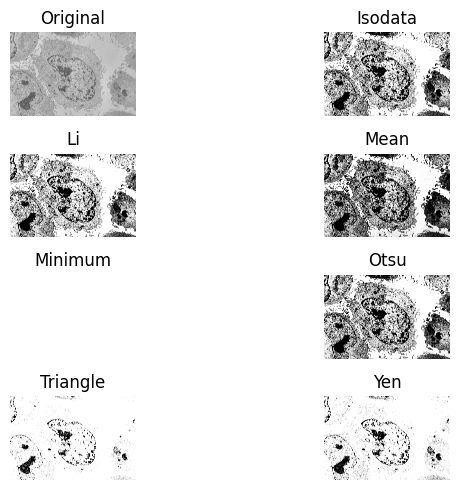

In [17]:
fig, ax = sk.filters.try_all_threshold(adpt_norm)

In [23]:
#trying yen threshold
mask = test_mask == 1
gauss = sk.filters.gaussian(adpt_norm, sigma=1)
masked_img = mask * gauss
yen = sk.filters.threshold_yen(image=gauss)
yen_mask = adpt_norm < yen
viewer = napari.view_image(adpt_norm)
viewer.add_labels(yen_mask)

<Labels layer 'yen_mask' at 0x1f9bca14ac0>

In [24]:
#trying triangle threshold
mask = test_mask == 1
gauss = sk.filters.gaussian(adpt_norm, sigma=1)
masked_img = mask * gauss
triangle = sk.filters.threshold_triangle(image=gauss)
triangle_mask = adpt_norm < triangle
viewer = napari.view_image(adpt_norm)
viewer.add_labels(triangle_mask)

<Labels layer 'triangle_mask' at 0x1f9bc8a3250>

In [ ]:
mask = test_mask == 1
gauss = sk.filters.gaussian(adpt_norm, sigma=1)
masked_img = mask * gauss
o1,o2,o3 = sk.filters.threshold_multiotsu(image=masked_img, classes=4)
# otsu1 = (masked_img < o1)*mask
otsu2 = (masked_img < o2)*mask
# otsu3 = (masked_img < o3)*mask
viewer = napari.view_image(adpt_norm, name='image')
#viewer.add_labels(otsu1, name='otsu1')
viewer.add_labels(otsu2, name='otsu2')
#viewer.add_labels(otsu3, name='otsu3')

ValueError: After discretization into bins, the input image has only 1 different values. It cannot be thresholded in 4 classes. If there are more unique values before discretization, try increasing the number of bins (`nbins`).

In [122]:
labeled_img = sk.morphology.label(otsu2)
props = ['label','area']
region_props = sk.measure.regionprops_table(labeled_img,properties=props)
df = pd.DataFrame.from_dict(region_props)
areas = np.asarray(df['area'])

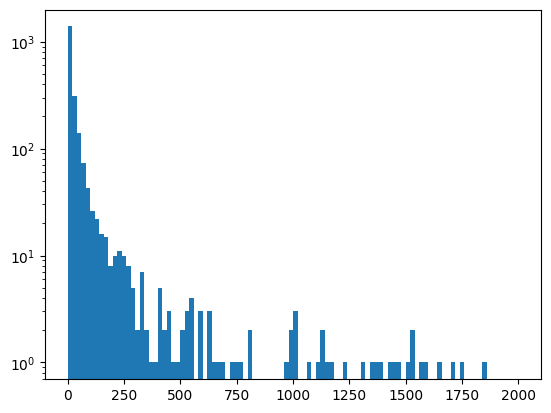

In [123]:
fig, ax = plt.subplots()
ax.hist(areas,bins=100,range=[0,2000])
ax.set_yscale('log')
plt.show()

In [124]:
#filter out small objects and fill holes
filtered = sk.morphology.remove_small_objects(sk.morphology.remove_small_holes(otsu2,area_threshold=10000),min_size=500)
viewer = napari.view_image(adpt_norm, name='img')
viewer.add_labels(filtered, name='labels')
viewer.add_labels(otsu2, name='otsu')

<Labels layer 'otsu' at 0x20fcccc2d40>

In [115]:
viewer.add_labels(band_25,name='band')

<Labels layer 'band' at 0x20fb2b50d00>

## Adding in measurements of heterochromatin in band and nucleoli in nuclei

In [ ]:
view